In [12]:
!pip install pandas

In [4]:
!pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)


In [8]:
!pip install numpy

In [ ]:
!pip install matplotlib

In [10]:
!pip install scikit-learn

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter


data = pd.read_csv("BankChurners.csv")
data = data.drop(["CLIENTNUM"], axis=1)
# data["Attrition_Flag"] = data["Attrition_Flag"].map({"Attrited Customer": 0,
#                                                      "Existing Customer": 1})


In [24]:
data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


In [25]:
def get_unique(x: np.ndarray, y: np.ndarray):
    x_set = np.array([x[0, :], ])
    y_set = np.array([y[0]])
    for i in range(len(x)):
        for j in range(len(x_set)):
            if all(x_set[j, :] == x[i, :]):
                break
        else:
            x_set = np.vstack((x_set, x[i, :]))
            y_set = np.vstack((y_set, y[i]))
    return x_set, y_set

def analyze_data(dataset: pd.core.frame.DataFrame, target_name: str,
                 max_diff: float):
    target_data_arr = dataset[target_name].values
    dataset = dataset.drop([target_name], axis=1)
    trash_features = []
    for feature_name in dataset.keys():
        feature_data = dataset[feature_name]
        feature_data_dict = dict() # feature_data_dict =
        # {<feature_i-data>:  {
        #                     "count": <numb of same feature_i-data>,
        #                     "pos_target": <numb of positive target for objects with this feature_i-data>,
        #                     "neg_target": <numb of negative target for objects with this feature_i-data>
        #                     }
        # }

        for idx, feat_i in enumerate(feature_data):
            if feature_data_dict.get(feat_i, None) is None:
                feature_data_dict[feat_i] = {"count": 1, "pos_target": 0, "neg_target": 0}
            else:
                feature_data_dict[feat_i]["count"] += 1

            if target_data_arr[idx] == 0:
                feature_data_dict[feat_i]["neg_target"] += 1
            else:
                feature_data_dict[feat_i]["pos_target"] += 1

        print(f"\n{feature_name} pos/neg target ratio:")
        feature_i_ratio = []
        for i in feature_data_dict.items():
            pos = i[1]['pos_target'] # number of positive target for objects with this feature_i-data
            neg = i[1]['neg_target'] # number of negative target for objects with this feature_i-data
            if (neg == 0 or pos == 0):
                info_str = f"{feature_name} : {i[0]} ,ratio = {pos} / {neg}"
            else:
                info_str = f"{feature_name} : {i[0]} ,ratio = {pos} / {neg} = {round(pos / neg, 3)} " \
                           f"\tpos_perc = {round(100 * pos / (pos + neg), 2)}%, " \
                           f"neg_perc = {round(100 * neg / (pos + neg), 2)}%"
                feature_i_ratio.append(pos / neg)
            print(info_str)
        if (max(feature_i_ratio) - min(feature_i_ratio) < max_diff):
            trash_features.append(feature_name)
    return trash_features

def identify_data_type(dataset: pd.core.frame.DataFrame):
    features_list = list(dataset.columns)
    features_types_dict = {"Categorical": [], "Numerical": []}
    for feature_name in features_list:
        if any([type_i in data[feature_name].dtype.name
                for type_i in ["int", "object"]]):
            features_types_dict["Categorical"].append(feature_name)
        elif "float" in data[feature_name].dtype.name:
            features_types_dict["Numerical"].append(feature_name)
    return features_types_dict

# dataset preparing

In [116]:
drop_features = [
    "Credit_Limit", "Total_Revolving_Bal",
    "Avg_Open_To_Buy", "Total_Amt_Chng_Q4_Q1",
    "Total_Ct_Chng_Q4_Q1", "Total_Trans_Amt",
    "Avg_Utilization_Ratio",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]

Le = LabelEncoder()
data["Attrition_Flag"] = Le.fit_transform(data["Attrition_Flag"].values)

analyze_data(dataset=data.drop(drop_features, axis=1), target_name="Attrition_Flag",
             max_diff=1.5)


Customer_Age pos/neg target ratio:
Customer_Age : 45 ,ratio = 407 / 79 = 5.152 	pos_perc = 83.74%, neg_perc = 16.26%
Customer_Age : 49 ,ratio = 416 / 79 = 5.266 	pos_perc = 84.04%, neg_perc = 15.96%
Customer_Age : 51 ,ratio = 340 / 58 = 5.862 	pos_perc = 85.43%, neg_perc = 14.57%
Customer_Age : 40 ,ratio = 297 / 64 = 4.641 	pos_perc = 82.27%, neg_perc = 17.73%
Customer_Age : 44 ,ratio = 416 / 84 = 4.952 	pos_perc = 83.2%, neg_perc = 16.8%
Customer_Age : 32 ,ratio = 89 / 17 = 5.235 	pos_perc = 83.96%, neg_perc = 16.04%
Customer_Age : 37 ,ratio = 223 / 37 = 6.027 	pos_perc = 85.77%, neg_perc = 14.23%
Customer_Age : 48 ,ratio = 387 / 85 = 4.553 	pos_perc = 81.99%, neg_perc = 18.01%
Customer_Age : 42 ,ratio = 364 / 62 = 5.871 	pos_perc = 85.45%, neg_perc = 14.55%
Customer_Age : 65 ,ratio = 92 / 9 = 10.222 	pos_perc = 91.09%, neg_perc = 8.91%
Customer_Age : 56 ,ratio = 219 / 43 = 5.093 	pos_perc = 83.59%, neg_perc = 16.41%
Customer_Age : 35 ,ratio = 163 / 21 = 7.762 	pos_perc = 88.59%, neg

['Gender', 'Dependent_count', 'Marital_Status']

In [153]:
features_types = identify_data_type(dataset=data)
numerical_features = features_types["Numerical"]
ordinal_features = ["Customer_Age", "Dependent_count", "Education_Level",
                "Income_Category", "Months_on_book", "Total_Relationship_Count",
                "Months_Inactive_12_mon", "Contacts_Count_12_mon"]
categorical_features = [i for i in features_types["Categorical"] if i not in ordinal_features]
# data[features_types["Categorical"]]
categorical_features

['Attrition_Flag',
 'Gender',
 'Marital_Status',
 'Card_Category',
 'Total_Revolving_Bal',
 'Total_Trans_Amt',
 'Total_Trans_Ct']

In [159]:
Counter(data[categorical_features]["Total_Revolving_Bal"])

Counter({777: 4,
         864: 6,
         0: 2470,
         2517: 508,
         1247: 7,
         2264: 5,
         1396: 9,
         1677: 4,
         1467: 2,
         1587: 6,
         1666: 5,
         680: 6,
         972: 5,
         2362: 3,
         1291: 8,
         1157: 5,
         1800: 5,
         1560: 10,
         1669: 5,
         1374: 3,
         1010: 9,
         1362: 6,
         1811: 5,
         1690: 4,
         1490: 6,
         1696: 9,
         1914: 2,
         2298: 1,
         886: 4,
         605: 2,
         578: 3,
         2204: 2,
         2055: 7,
         1430: 9,
         2020: 2,
         1435: 8,
         1227: 4,
         1549: 8,
         808: 6,
         2179: 3,
         2200: 4,
         2363: 1,
         1880: 7,
         978: 6,
         1753: 5,
         2016: 6,
         1251: 9,
         2102: 2,
         1634: 5,
         1515: 7,
         1817: 8,
         1468: 7,
         1107: 4,
         1330: 2,
         1763: 4,
         1034: 4

In [189]:
data1 = data[ordinal_features[2: 4]]
list(zip(Le.fit_transform(data1["Education_Level"].values), data1["Education_Level"].values))
data1["Education_Level"].unique()

array(['High School', 'Graduate', 'Uneducated', 'Unknown', 'College',
       'Post-Graduate', 'Doctorate'], dtype=object)

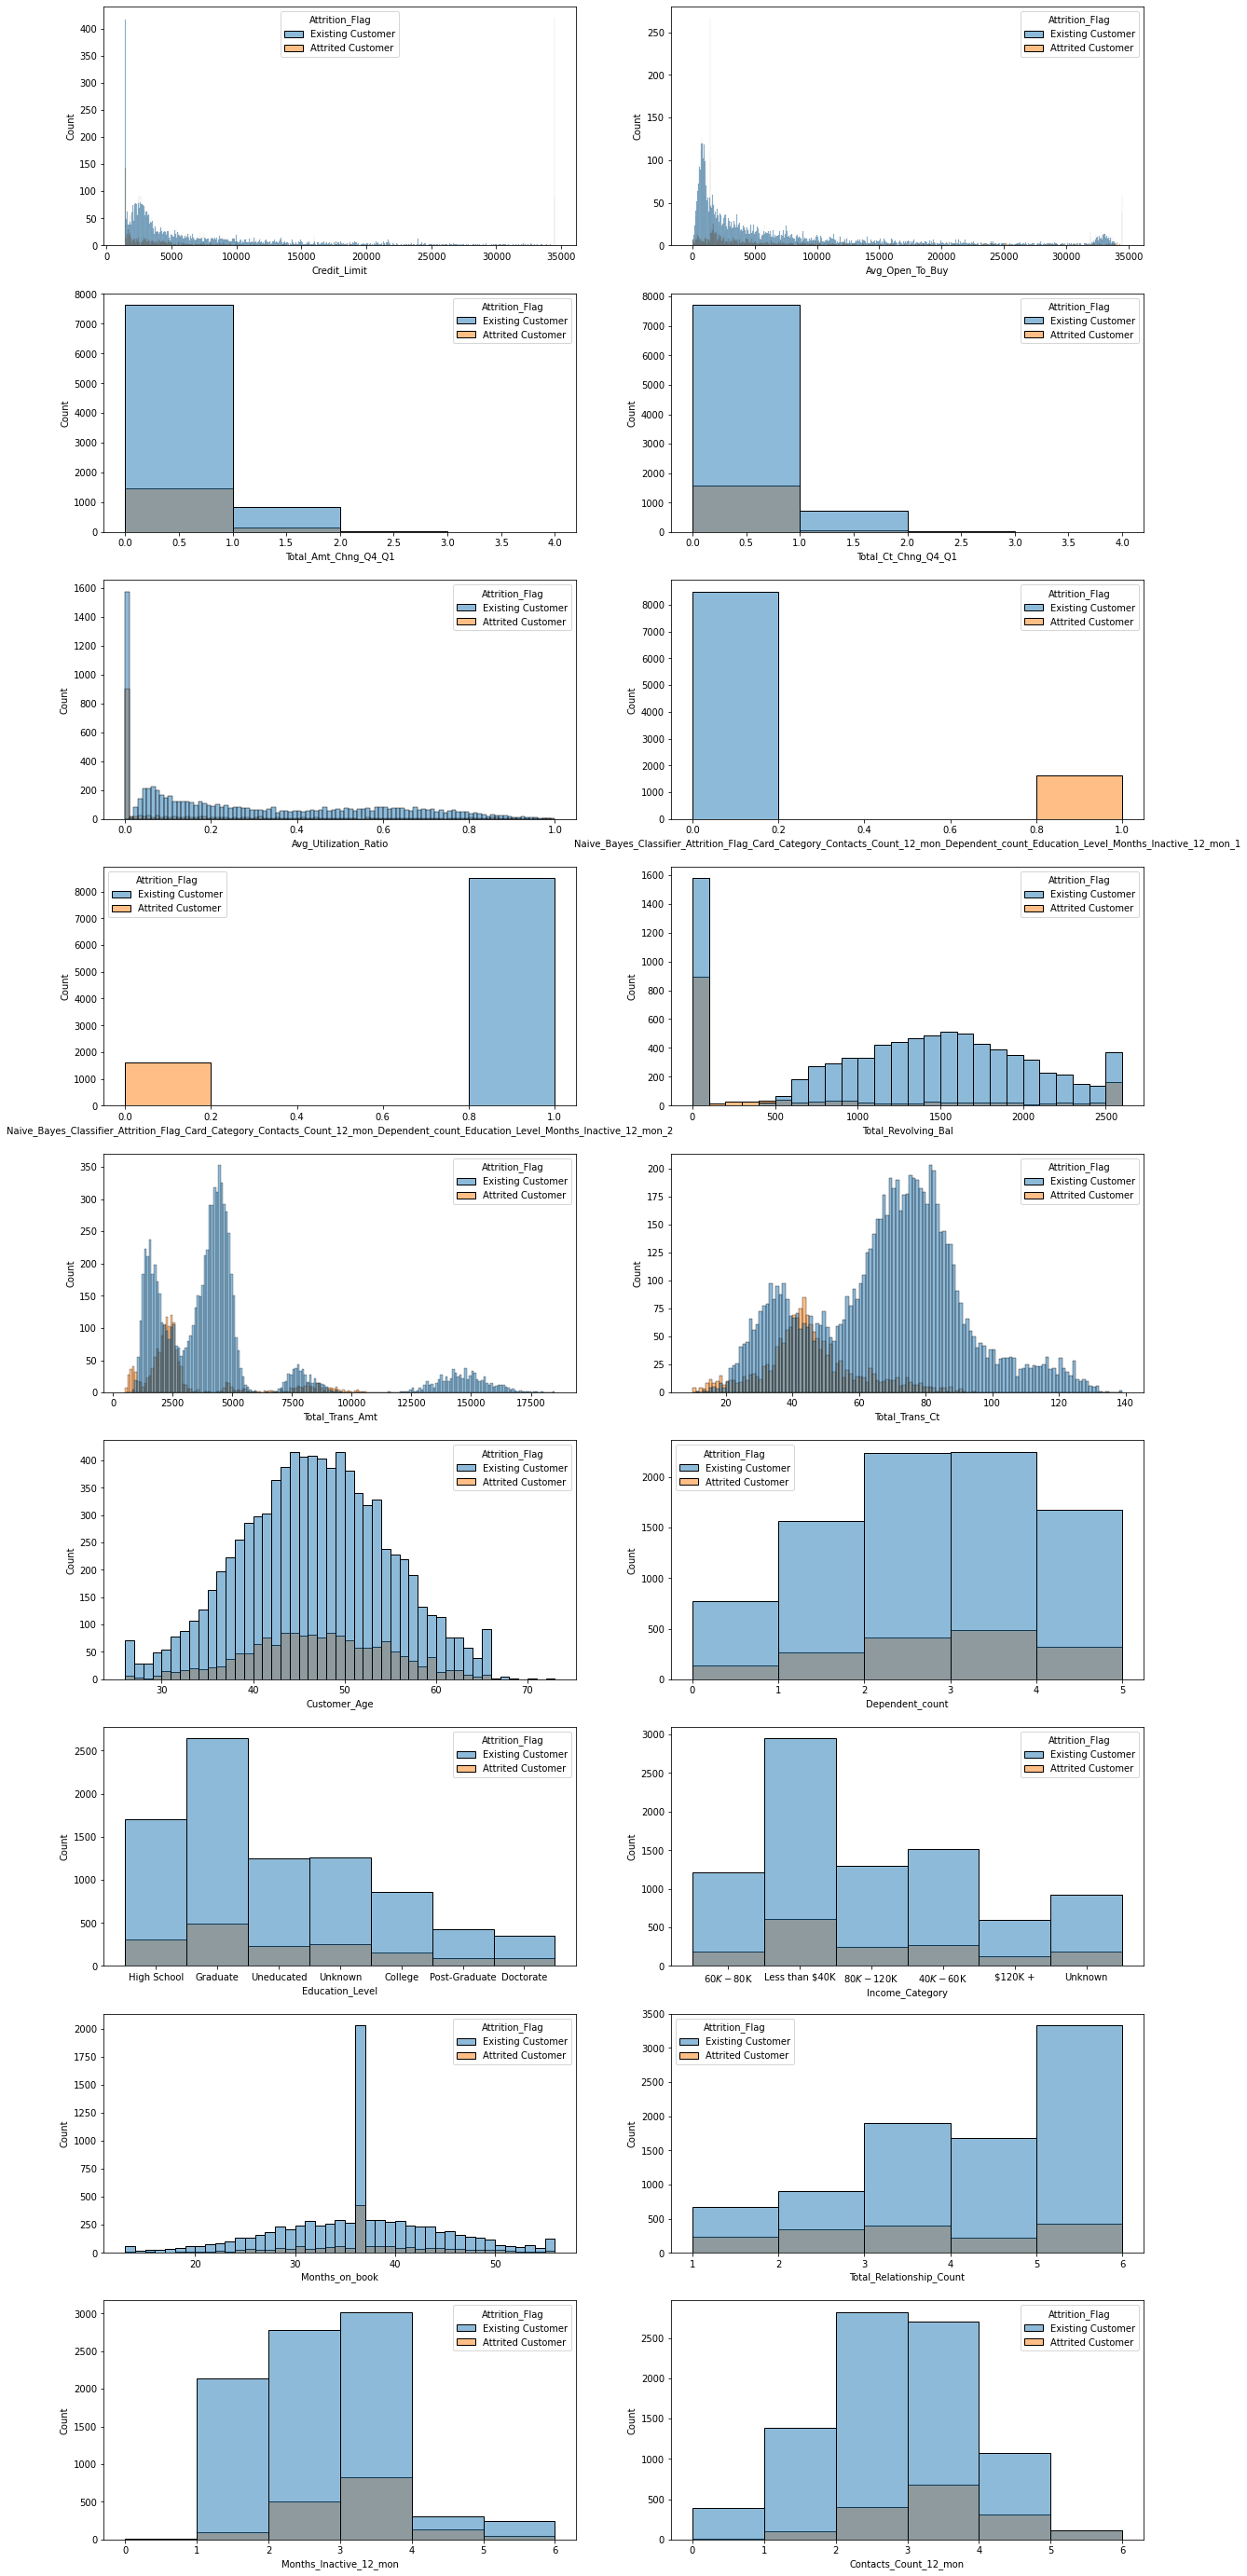

In [25]:
user_binwidth = 40
plt.figure(figsize=((20, 50)))
figures_numb_in_row = 2
hist_vizual_data = data[[*numerical_features,
                         *categorical_features[-3:],
                         *ordinal_features]]
for idx, feature in enumerate(hist_vizual_data):
    if(idx < 21):
        if (feature in numerical_features[-2:]):
            user_binwidth = 0.2
        if (feature in numerical_features[:2]):
            user_binwidth = 40
        if feature in categorical_features[-3: -1]:
            user_binwidth = 100
        if feature == "Avg_Utilization_Ratio":
            user_binwidth = 0.01
        plt.subplot(hist_vizual_data.shape[1] // figures_numb_in_row + (0 if(hist_vizual_data.shape[1] % figures_numb_in_row == 0) else 1),
                    figures_numb_in_row, idx + 1)
        sns.histplot(x=feature,
                     data=data[[feature, "Attrition_Flag"] if feature != "Attrition_Flag" else [feature]],
                     color=["blue", "green"], hue="Attrition_Flag", binwidth=user_binwidth)
        user_binwidth = 1


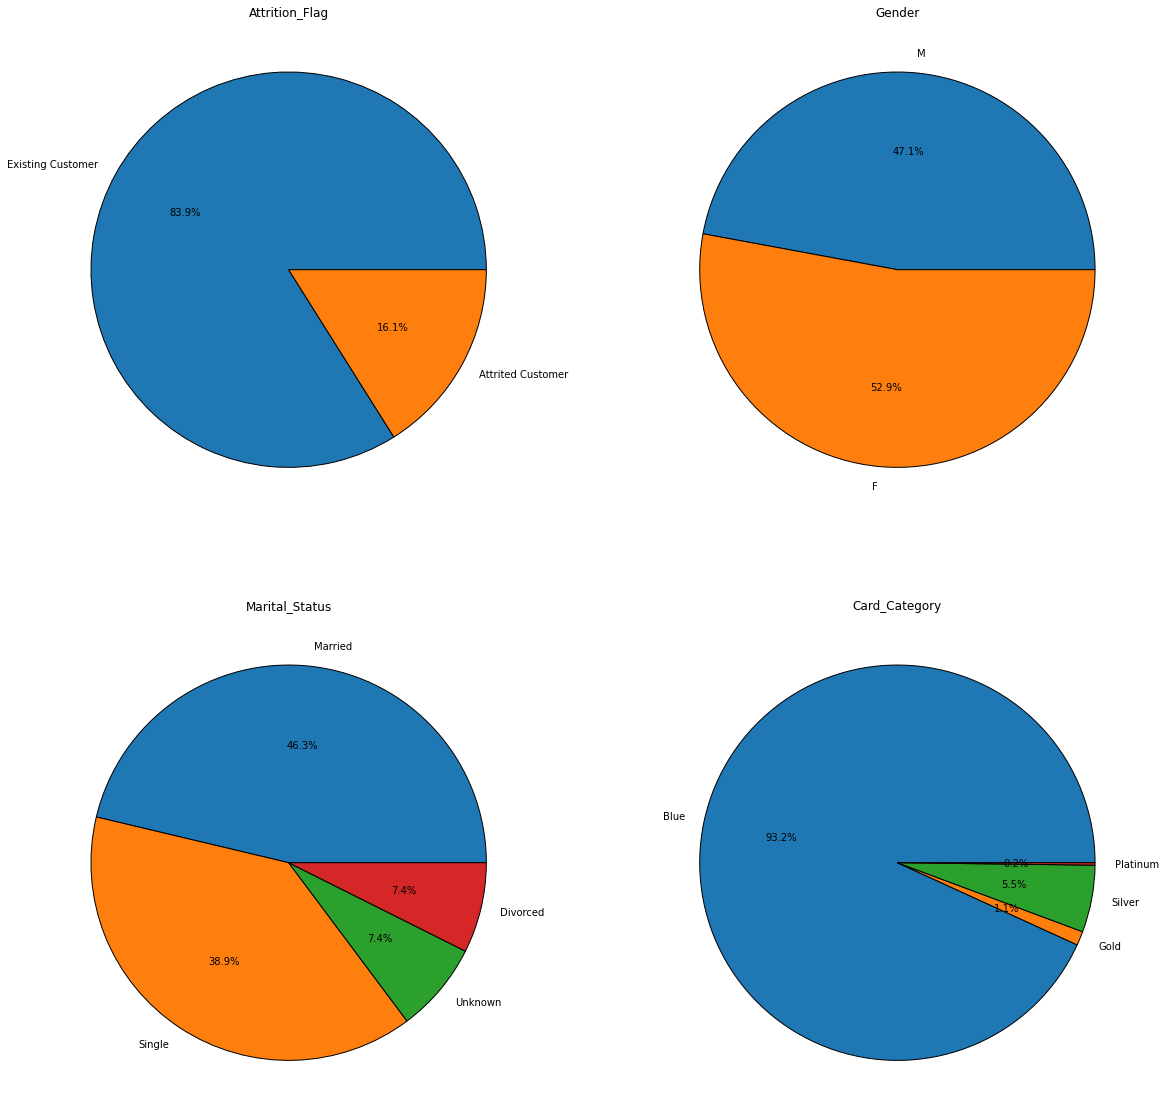

In [207]:
plt.figure(figsize=((20, 20)))
figures_numb_in_row = 2
pie_vizual_data = data[categorical_features[: -3]]
for idx, feature in enumerate(pie_vizual_data):
    if 1:
        plt.subplot(pie_vizual_data.shape[1] // figures_numb_in_row + (0 if(pie_vizual_data.shape[1] % figures_numb_in_row == 0) else 1),
                    figures_numb_in_row, idx + 1)
        c = Counter(pie_vizual_data[feature])
        plt.title(feature)
        plt.pie(c.values(), labels=c.keys(), wedgeprops={"edgecolor": "black"}, autopct='%1.1f%%')

In [191]:
data[numerical_features[-2:]]


,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,0.000093,0.999910
1,0.000057,0.999940
2,0.000021,0.999980
3,0.000134,0.999870
4,0.000022,0.999980
...,...,...
10122,0.000191,0.999810
10123,0.995270,0.004729
10124,0.997880,0.002118
10125,0.996710,0.003294


<AxesSubplot:xlabel='Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', ylabel='Count'>

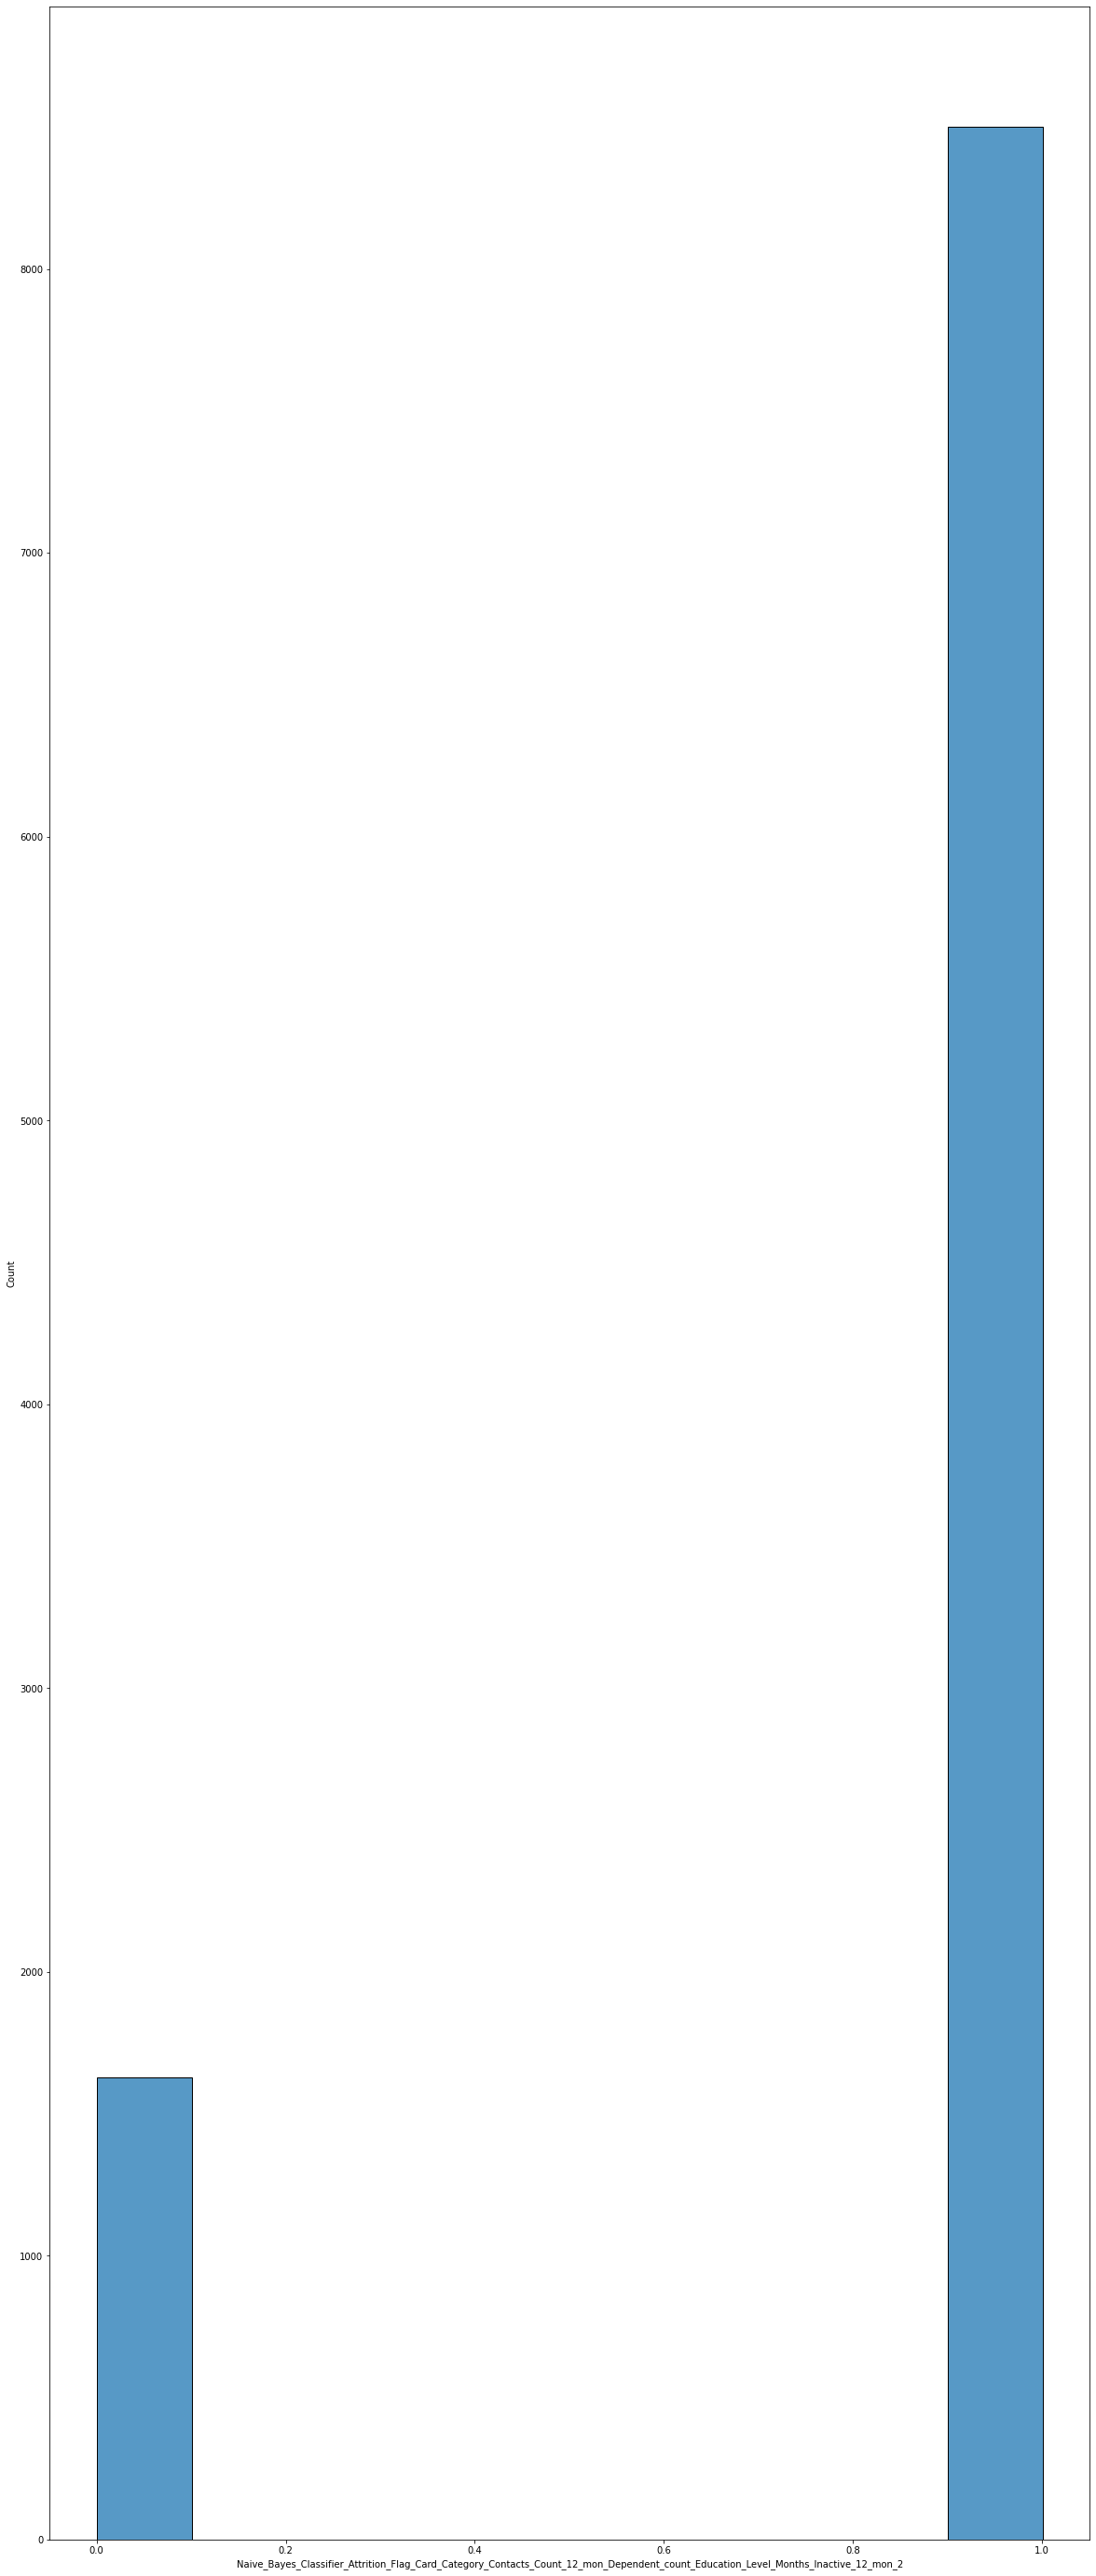

In [199]:
plt.figure(figsize=((20, 50)))
plt.subplot(1, 1, 1)
sns.histplot(data=data[numerical_features[-2:]], x=numerical_features[-1], binwidth=0.1, )

([<matplotlib.patches.Wedge at 0x149948d4940>,
 [Text(0.10035590564411727, 1.0954125671190509, 'M'),
  Text(-0.10035590564411717, -1.0954125671190509, 'F')])

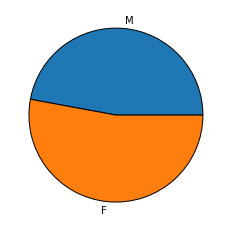

In [150]:
data1 = data[categorical_features]
data1 = data1[data1.columns[2]]
c = Counter(data1)
plt.pie(c.values(), labels=c.keys(), wedgeprops={"edgecolor": "black"})